Environment package and version in requirement.txt (pip list --format=freeze > requirements.txt)
To recreate environment do pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
from io import StringIO
from scipy.spatial import cKDTree # create KDTree
import matplotlib.pyplot as plt

import fafbseg # API
from fafbseg import flywire
import caveclient

import networkx as nx # create tree based on SWC
import navis

import jax
import jaxley as jx
import jax.numpy as jnp # numpy in jax
from jaxley.channels import Na, K, Leak # Mechanism

from jax import config # Device
config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)
#print(jax.devices())


from jax import jit, vmap, value_and_grad # Simulation and optimization
import optax
import tensorflow as tf
from tensorflow.data import Dataset

Read in first 2000 lines of final SWC file (soma replaced) and create a new SWC file; real compartment number might not be 2000 due to some smoothing/thresholding behavior of Jaxley creating a cell

In [ ]:
input_file = "MBON-18_final.swc"
output_file = "MBON-18_sub.swc"

# Open the input SWC file and read the first 50 lines
with open(input_file, 'r') as infile:
    lines = infile.readlines()

# Write the first 50 lines to the output SWC file
with open(output_file, 'w') as outfile:
    outfile.writelines(lines[:50])

print(f"New SWC file created with the first 50 lines: {output_file}")

New SWC file created with the first 50 lines: MBON-18_sub.swc


Create a cell instance with proper mechanism

Create a cell instance with proper mechanism--Morphology

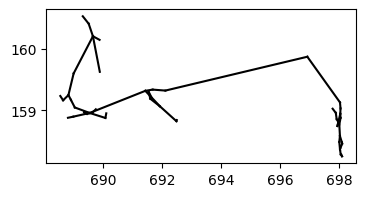

In [ ]:
fileName = "MBON-18_sub.swc"
# Cell instance
cell = jx.read_swc(fileName, nseg=1)
cell.compute_xyz()  # Only needed for visualization.
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax, col="k")

Create a cell instance with proper mechanism--Mechanism: Parameters to optimize are leak channel, axial resistivity, and capacitance

In [ ]:
data = pd.read_excel("beta2beta'2normalisedmean.xlsx", header = None)
v_exp = data.iloc[3, 1:].values
v_exp = -60.04 * v_exp -60.04
v_exp = v_exp.tolist() # Jax only handles arrays
v_exp_np = np.array(v_exp)
v_exp = jnp.array(v_exp) # From array to jnp (Jax's version of ndarray)

print (len(v_exp))

9200


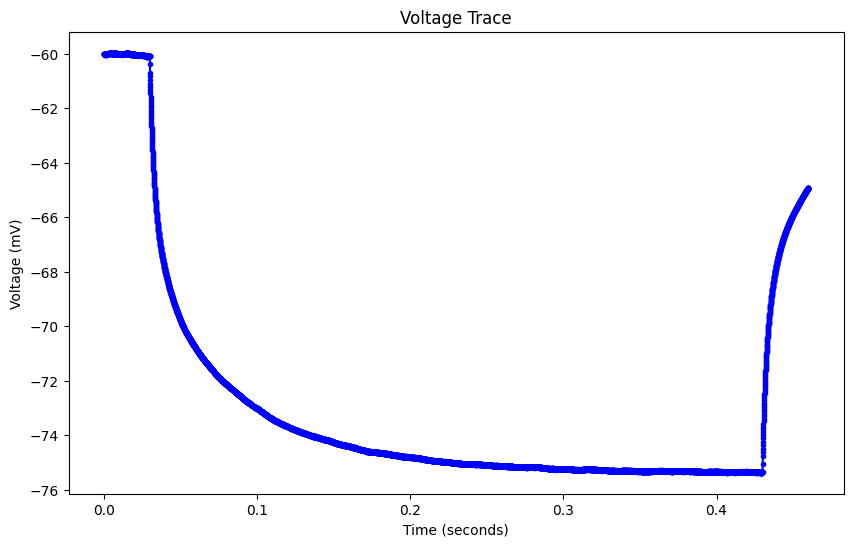

In [ ]:
# Assuming v_exp_np is your voltage data, and its length is N
N = len(v_exp_np)
time = np.arange(0.00005, (N+1) * 0.00005, 0.00005)  # Create a time array based on the 0.00005 sec interval

plt.figure(figsize=(10, 6))
plt.plot(time, v_exp_np, marker='.', linestyle='-', color='b')  # Plot voltage vs. time
plt.title('Voltage Trace')
plt.xlabel('Time (seconds)')  # Adjusted to reflect time in seconds
plt.ylabel('Voltage (mV)')
plt.show()


RC circuit behavior for initial guess

In [ ]:
cell.insert(Leak())
cell.set("Leak_gLeak", 9.0E-6)
cell.set("Leak_eLeak", -60.04)
cell.set("axial_resistivity", 100)
cell.set("capacitance", 0.7)
cell.set("v", -60.04)

Create a network (with one cell) for optimization: training a network

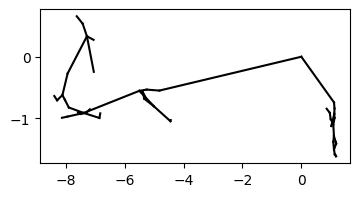

In [ ]:
# Network to be trained
net = jx.Network([cell for _ in range(1)])
net.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = net.vis(ax=ax, detail="full", layers=[1])

Define trainable variables

In [ ]:
net.delete_trainables()
net.make_trainable("Leak_gLeak")
net.make_trainable("axial_resistivity")
net.make_trainable("capacitance")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3


Recording

In [ ]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.5).record() # Center of soma

Added 1 recordings. See `.recordings` for details.


Load data

Running simulation

In [ ]:
params = net.get_parameters()
s = jx.integrate(net, params=params, t_max=460)

Stimulating the network
might want to change delta_t in currents. 0.025 was based on tutorial of Jaxley

In [ ]:
# Checkpointing reduces memory requirement
t_max = 460.0
dt = 0.05 # try 0.5

levels = 1 # 1 level network
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

In [ ]:
def simulate(params):
    currents = jx.datapoint_to_step_currents(i_delay=30.0, i_dur=400.0, i_amp= [-0.01], delta_t=0.05, t_max=460.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).loc(0.5).data_stimulate(currents[0], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli)

Check dimension

In [ ]:
trace = simulate(params)
print(trace.shape)

(1, 9202)


Initial trace

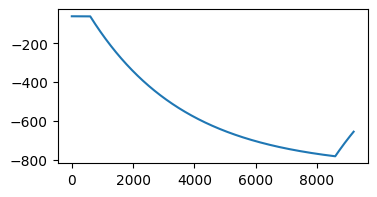

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(trace[0, :].T)

Before training, we will enforce for all parameters to be within a prespecified range

In [ ]:
transform = jx.ParamTransform(
    lowers={
        "Leak_gLeak": 1e-6,
        "axial_resistivity": 30,
        "capacitance": 0.6,
    },
    uppers={
        "Leak_gLeak": 1.2e-4,
        "axial_resistivity": 400,
        "capacitance": 2.6,
    }, 
)

Loss function

In [ ]:
def loss(opt_params, v_exp):
    params = transform.forward(opt_params)
    v_sim = simulate(params)[0, 1:-1]  # Ensure this also returns a JAX array
    return jnp.mean((v_sim - v_exp)**2)  # sum of squared differences


# JIT compile the loss function and its gradient
jitted_grad = jit(value_and_grad(loss, argnums=0))

# Convert params to JAX arrays if they aren't already
value, gradient = jitted_grad(params, v_exp)  # Ensure v_exp is a JAX array here as well



Training phase

In [ ]:
opt_params = transform.inverse(params)
optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(opt_params)

Dataloader

In [ ]:
tf.random.set_seed(1)

Verification and fitness test

In [ ]:
for epoch in range (40):
    epoch_loss = 0.0
    loss_val, gradient = jitted_grad(opt_params, v_exp)
    updates, opt_state = optimizer.update(gradient, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)
    epoch_loss += loss_val
    print(f"epoch {epoch}, loss {epoch_loss}")
    
final_params = transform.forward(opt_params)

epoch 0, loss 267654.2839366504
epoch 1, loss 69355.53870263255
epoch 2, loss 19891.25009644851
epoch 3, loss 8040.572034709018
epoch 4, loss 4431.127147851485
epoch 5, loss 3039.353047851577
epoch 6, loss 2398.0975643388724
epoch 7, loss 2062.383472876586
epoch 8, loss 1869.5926995664022
epoch 9, loss 1750.9572787899713
epoch 10, loss 1673.9442631086029
epoch 11, loss 1621.7684097805509
epoch 12, loss 1585.1579018214316
epoch 13, loss 1558.7027048516647
epoch 14, loss 1539.100591158878
epoch 15, loss 1524.2585006823595
epoch 16, loss 1512.8063223708114
epoch 17, loss 1503.821879080462
epoch 18, loss 1496.6691298339995
epoch 19, loss 1490.8997778561652
epoch 20, loss 1486.1917099979728
epoch 21, loss 1482.309368742918
epoch 22, loss 1479.0777651148767
epoch 23, loss 1476.3650477515985
epoch 24, loss 1474.070522226064
epoch 25, loss 1472.1163163942228
epoch 26, loss 1470.4416275472427
epoch 27, loss 1468.998355917841
epoch 28, loss 1467.7481853035792
epoch 29, loss 1466.66028703096
epoc